<a href="https://colab.research.google.com/github/emilyannakoshy/Sentimental-Analysis/blob/main/SentimentalAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Collection**

In [ ]:
!mkdir ~/.kaggle #creates a directory named .kaggle
!cp kaggle.json ~/.kaggle/ # copies the kaggle.json file (which contains  Kaggle API credentials) into the .kaggle directory
!chmod 600 ~/.kaggle/kaggle.json #

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
! kaggle datasets download -d cosmos98/twitter-and-reddit-sentimental-analysis-dataset

Dataset URL: https://www.kaggle.com/datasets/cosmos98/twitter-and-reddit-sentimental-analysis-dataset
License(s): CC-BY-NC-SA-4.0
 50% 5.00M/10.0M [00:00<00:00, 27.9MB/s]
100% 10.0M/10.0M [00:00<00:00, 50.9MB/s]


In [ ]:
!unzip twitter-and-reddit-sentimental-analysis-dataset

Archive:  twitter-and-reddit-sentimental-analysis-dataset.zip
  inflating: Reddit_Data.csv         
  inflating: Twitter_Data.csv        


In [ ]:
import pandas as pd

In [ ]:
df_sentiment = pd.read_csv("Twitter_Data.csv")
df_sentiment.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


The dataset is already cleaned using Pythons re and also NLP


# **Data Preprocessing**

In [ ]:
#checking the null values
df_sentiment['category'].isnull().sum()

7

In [ ]:
# Fill null values with the mode (most frequent value)
mode_value = df_sentiment['category'].mode()[0]
df_sentiment['category'] = df_sentiment['category'].fillna(mode_value)


# **Feature Extraction**

In [ ]:
import gensim.downloader as api

In [ ]:
word2vec_model = api.load("word2vec-google-news-300")
print("Vocabulary Size:", len(word2vec_model.key_to_index))
print("Vector Size:", word2vec_model.vector_size)


[==================================================] 100.0% 1662.8/1662.8MB downloaded
Vocabulary Size: 3000000
Vector Size: 300


In [ ]:
import numpy as np
import nltk
from nltk.tokenize import word_tokenize

In [ ]:
# Download the punkt tokenizer
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Function to get average vector for a text
def get_average_vector(text, model, vector_size):
    tokens = word_tokenize(text)
    valid_tokens = [token for token in tokens if token in model.key_to_index]
    if not valid_tokens:
        return np.zeros(vector_size)

    vectors = [model[token] for token in valid_tokens]
    return np.mean(vectors, axis=0)


In [ ]:
# Check the types of values in 'clean_text' column and apply preprocessing
df_sentiment['clean_text'] = df_sentiment['clean_text'].astype(str)

In [ ]:
# Apply the function to the 'clean_text' column
vector_size = word2vec_model.vector_size
df_sentiment['word2vec'] = df_sentiment['clean_text'].apply(lambda text: get_average_vector(text, word2vec_model, vector_size))

In [ ]:
print(df_sentiment['word2vec'].head())

0    [0.030494427, 0.044749293, 0.050368737, 0.0614...
1    [0.037319183, 0.035909016, 0.052057903, 0.0934...
2    [0.0076071997, 0.017836832, 0.10184825, 0.1116...
3    [0.06428248, 0.059002932, 0.08365496, 0.074983...
4    [0.0282353, 0.030356271, 0.06876046, 0.1004965...
Name: word2vec, dtype: object


# **Sentiment classification using logistic regression**

In [ ]:
#converting list of vectors into numpy array
X = np.array(df_sentiment['word2vec'].tolist())

In [ ]:
#define the target variable
y = df_sentiment['category']

In [ ]:
from sklearn.model_selection import train_test_split
#splitting data into train,test
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [ ]:
from sklearn.linear_model import LogisticRegression
# Initialize and train Logistic Regression model
model = LogisticRegression(max_iter=1000)  # Increase max_iter if convergence warning occurs
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Predict on the test set
y_pred = model.predict(X_test)

In [ ]:
# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.666441690186935
Classification Report:
               precision    recall  f1-score   support

        -1.0       0.60      0.42      0.50     10717
         0.0       0.67      0.68      0.68     16550
         1.0       0.68      0.78      0.73     21627

    accuracy                           0.67     48894
   macro avg       0.65      0.63      0.63     48894
weighted avg       0.66      0.67      0.66     48894



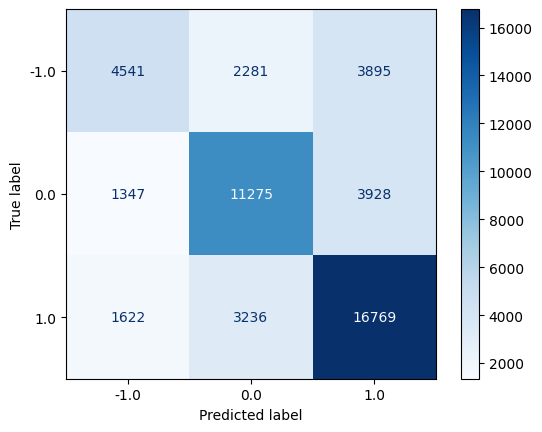

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
import matplotlib.pyplot as plt

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()
